In [53]:
import os
import time
import traceback
import numpy as np
import pandas as pd
from dataloader import TrimodalLoader
from model import TrimodalModel
import torch


## Process
1. Load all data
2. Sub or oversample so that all dataset samples align
3. Form inputs of shape [mod1_x, mod2_x, mod3_x], [y]
4. Train embracenet

In [54]:
def load_iris():
    """Loads iris features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../iris/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"iris_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels
        

In [55]:
def load_fingerprint():
    """Loads fingerprint features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../fingerprint/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"fp_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [56]:
def load_face():
    """Loads face features into a dataframe

    Returns:
        pd.DataFrame: dataframe containing iris features
        python list of labels    
    """
    path = "../face/features"
    
    embs = os.listdir(path)
    
    labels, embeddings = [], []
    
    for emb in embs:
        
        label = emb.split("_")[0].replace("sub", "")
        label = int(label)
        
        emb = np.load(os.path.join(path, emb))
        
        labels.append(label)
        embeddings.append(emb)
        
    cols = [f"face_{i}" for i in range(len(embeddings[0]))]
    embeddings = pd.DataFrame(embeddings, columns=cols)    
    
    return embeddings, labels

In [57]:
if len(os.listdir("feats")) == 0:
    emb_iris, lab_iris = load_iris()
    emb_fp, lab_fp = load_fingerprint()
    emb_face, lab_face = load_face()
else:
    emb_iris = pd.read_csv("feats/iris.csv")
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

In [58]:
if len(os.listdir("feats")) == 0:

    print(len(lab_iris), len(lab_fp), len(lab_face))
    emb_iris["label"] = lab_iris
    emb_fp["label"] = lab_fp
    emb_face["label"] = lab_face

    emb_iris.to_csv("feats/iris.csv", index=False)
    emb_fp.to_csv("feats/fingerprint.csv", index=False)
    emb_face.to_csv("feats/face.csv", index=False)

else:
    emb_iris = pd.read_csv("feats/iris.csv")    
    emb_fp = pd.read_csv("feats/fingerprint.csv")
    emb_face = pd.read_csv("feats/face.csv")

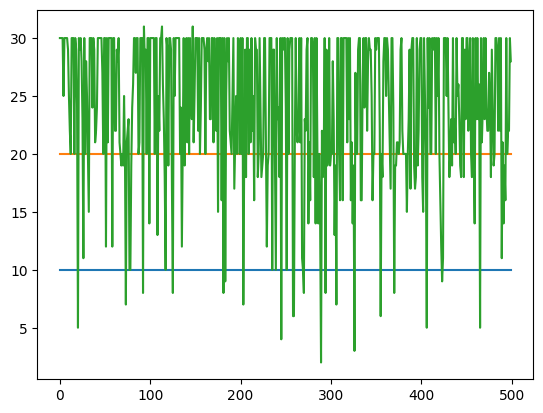

In [59]:
import matplotlib.pyplot as plt
plt.plot(emb_iris["label"].value_counts().sort_index())
plt.plot(emb_fp["label"].value_counts().sort_index())
plt.plot(emb_face["label"].value_counts().sort_index()) 

In [ ]:
def get_fusion(df1, df2, df3):
    """
    Concatenates three dataframes into a single dataframe with pairs of embeddings and labels.

    Parameters:
        df1, df2, df3 (pd.DataFrame): DataFrames containing embeddings and labels.
        
    Returns:
        pd.DataFrame: A concatenated DataFrame with balanced pairs of embeddings and labels.
    """
    final_df1 = pd.DataFrame()
    final_df2 = pd.DataFrame()
    final_df3 = pd.DataFrame()
    
    
    # Iterate over unique labels
    for label in df1['label'].unique():
        # Filter each DataFrame for the current label
        sub_df1 = df1[df1['label'] == label]
        sub_df2 = df2[df2['label'] == label]
        sub_df3 = df3[df3['label'] == label]
        
        # Determine the maximum number of samples across the three DataFrames
        num_samples = min(len(sub_df1), len(sub_df2), len(sub_df3))
        
        # Oversample each subset to match the maximum sample size
        sub_df1 = sub_df1.sample(num_samples, replace=False).reset_index(drop=True)
        sub_df2 = sub_df2.sample(num_samples, replace=False).reset_index(drop=True)
        sub_df3 = sub_df3.sample(num_samples, replace=False).reset_index(drop=True)
        
        final_df1 = pd.concat([final_df1, sub_df1], axis=0)
        final_df2 = pd.concat([final_df2, sub_df2], axis=0)
        final_df3 = pd.concat([final_df3, sub_df3], axis=0)
        
    
    return final_df1, final_df2, final_df3


In [66]:
def remap_labels(emb_iris, emb_face, emb_fp):
    mapping = {val: idx for idx, val in enumerate(emb_iris["label"].unique())}
    
    emb_iris["label"] = emb_iris["label"].map(mapping)
    emb_face["label"] = emb_face["label"].map(mapping)
    emb_fp["label"] = emb_fp["label"].map(mapping)
    
    return emb_iris, emb_face, emb_fp

In [68]:
# if "iris_sampled.csv" not in os.listdir("feats"):
emb_iris, emb_face, emb_fp = get_fusion(emb_iris, emb_face, emb_fp)

emb_iris, emb_face, emb_fp = remap_labels(emb_iris, emb_face, emb_fp)

emb_iris.to_csv("feats/iris_sampled.csv", index=False)
emb_fp.to_csv("feats/fingerprint_sampled.csv", index=False)
emb_face.to_csv("feats/face_sampled.csv", index=False)

# else:
#     emb_iris = pd.read_csv("feats/iris_sampled.csv")
#     emb_fp = pd.read_csv("feats/fingerprint_sampled.csv")
#     emb_face = pd.read_csv("feats/face_sampled.csv")

In [72]:
emb_iris.reset_index(drop=True, inplace=True)
emb_fp.reset_index(drop=True, inplace=True)
emb_face.reset_index(drop=True, inplace=True)


len(emb_iris), len(emb_face), len(emb_fp)

(12603, 12603, 12603)

Split within persons

In [73]:

# Prepare dataloader
percent_train = .7

train_indices_iris = []
train_indices_face = []
train_indices_fp = []

for label in emb_iris["label"].unique():
    train_indices_iris += list(emb_iris[emb_iris["label"] == label].index[:int(len(emb_iris[emb_iris["label"] == label]) * percent_train)])
    train_indices_face += list(emb_face[emb_face["label"] == label].index[:int(len(emb_face[emb_face["label"] == label]) * percent_train)])
    train_indices_fp += list(emb_fp[emb_fp["label"] == label].index[:int(len(emb_fp[emb_fp["label"] == label]) * percent_train)])

train_indices_iris = sorted(train_indices_iris)
train_indices_face = sorted(train_indices_face)
train_indices_fp = sorted(train_indices_fp)

print(train_indices_face)
print(emb_iris.drop(train_indices_iris).index)

iris_train = emb_iris.loc[train_indices_iris]
fp_train = emb_fp.loc[train_indices_fp]
face_train = emb_face.loc[train_indices_face]

iris_test = emb_iris.drop(train_indices_iris)
fp_test = emb_fp.drop(train_indices_fp)
face_test = emb_face.drop(train_indices_face)

iris_train_x, iris_train_y = iris_train.drop("label", axis=1), iris_train["label"]
fp_train_x, fp_train_y = fp_train.drop("label", axis=1), fp_train["label"]
face_train_x, face_train_y = face_train.drop("label", axis=1), face_train["label"]


iris_test_x, iris_test_y = iris_test.drop("label", axis=1), iris_test["label"]
fp_test_x, fp_test_y = fp_test.drop("label", axis=1), fp_test["label"]
face_test_x, face_test_y = face_test.drop("label", axis=1), face_test["label"]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 305, 306, 307, 30

KeyboardInterrupt: 

In [ ]:
set(iris_train_y) == set(fp_train_y) == set(face_train_y) == set(iris_test_y) == set(fp_test_y) == set(face_test_y)

True

In [ ]:
iris_train = iris_train.drop(columns="label")

In [ ]:
list(iris_train_y)[:10], list(fp_train_y)[:10], list(face_train_y)[:10]

([0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
len(iris_train_y), len(fp_train_y), len(face_train_y)

(8745, 8745, 8745)

In [ ]:
list(iris_train_y) == list(fp_train_y) == list(face_train_y)

True

In [ ]:
list(iris_test_y) == list(fp_test_y) == list(face_test_y)

True

In [ ]:
# We only need one set of labels
y = iris_train_y

In [ ]:
dataloader = TrimodalLoader(
    torch.tensor(iris_train_x.values, dtype=torch.float32), 
    torch.tensor(fp_train_x.values, dtype=torch.float32), 
    torch.tensor(face_train_x.values, dtype=torch.float32), 
    torch.tensor(list(y), dtype=torch.long))

test_loader = TrimodalLoader(
    torch.tensor(iris_test_x.values, dtype=torch.float32), 
    torch.tensor(fp_test_x.values, dtype=torch.float32), 
    torch.tensor(face_test_x.values, dtype=torch.float32), 
    torch.tensor(list(y), dtype=torch.long))

In [ ]:
test_loader.reset()

In [ ]:
ys = []
d = ""
while d is not None:
    d, l = test_loader.get_batch(32)
    if d is None:
        break
    print(l)
    l = [int(i) for i in l]
    ys.extend(l)

[array(83, dtype=int64), array(65, dtype=int64), array(202, dtype=int64), array(43, dtype=int64), array(95, dtype=int64), array(142, dtype=int64), array(143, dtype=int64), array(33, dtype=int64), array(143, dtype=int64), array(83, dtype=int64), array(206, dtype=int64), array(211, dtype=int64), array(111, dtype=int64), array(55, dtype=int64), array(156, dtype=int64), array(181, dtype=int64), array(146, dtype=int64), array(164, dtype=int64), array(184, dtype=int64), array(15, dtype=int64), array(113, dtype=int64), array(107, dtype=int64), array(16, dtype=int64), array(194, dtype=int64), array(164, dtype=int64), array(67, dtype=int64), array(50, dtype=int64), array(88, dtype=int64), array(203, dtype=int64), array(103, dtype=int64), array(148, dtype=int64), array(182, dtype=int64)]
[array(187, dtype=int64), array(45, dtype=int64), array(140, dtype=int64), array(63, dtype=int64), array(28, dtype=int64), array(98, dtype=int64), array(112, dtype=int64), array(48, dtype=int64), array(155, dtyp

In [ ]:
set(ys)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
iris_train.iloc[0].shape

(1408,)

In [ ]:
# initialize
batch_size = 32
device = "cpu"
train_path = "tmp/train/"
max_steps = 3
log_freq = 2
summary_freq = 5
save_freq = 5
sleep_ratio = 0
restore_path = None
global_step = 0
os.environ["CUDA_VISIBLE_DEVICES"] = device
os.makedirs(train_path, exist_ok=True)

In [ ]:
# Prepare model
model = TrimodalModel()
input_size_list = [iris_train.iloc[0].shape[0], fp_train_x.iloc[0].shape[0], face_train_x.iloc[0].shape[0]]
print(input_size_list)

print(input_size_list)
n_classes = iris_train_y.nunique()
print("N classes: ", n_classes)
model.prepare(is_training=True, input_size_list=input_size_list, global_step=global_step, n_classes=n_classes)

[1408, 1408, 512]
[1408, 1408, 512]
N classes:  500
Created docking_0 with input size 1408 and output size 512
Parameter containing:
tensor([[-2.2091e-02,  6.5727e-03,  4.7193e-03,  ..., -3.4883e-03,
          6.2574e-03, -2.0653e-02],
        [ 1.6853e-02, -1.8342e-02,  1.0097e-02,  ..., -6.4839e-03,
         -6.9846e-03,  2.3777e-03],
        [-1.3382e-02,  1.1889e-03,  1.4480e-02,  ...,  1.7078e-02,
          2.4088e-03,  1.6033e-02],
        ...,
        [ 1.0930e-02, -1.9867e-03,  2.4073e-02,  ...,  2.4697e-02,
         -5.1823e-05,  2.5118e-02],
        [-1.3141e-02, -1.4389e-02,  2.5451e-02,  ..., -6.6937e-03,
         -2.0818e-02, -9.1112e-03],
        [-1.5493e-02,  5.7501e-03, -2.4138e-02,  ..., -1.2211e-02,
          1.2697e-03,  7.9566e-03]], requires_grad=True)
Created docking_1 with input size 1408 and output size 512
Parameter containing:
tensor([[-0.0124, -0.0174,  0.0228,  ...,  0.0007,  0.0089, -0.0106],
        [-0.0006, -0.0086, -0.0058,  ..., -0.0110, -0.0151,  0.0

In [ ]:
# model > restore
if restore_path is not None:
    model.restore(ckpt_path=restore_path)
    print("restored the model")

# model > summary
summary_path = os.path.join(train_path, "summary")

In [ ]:
iris_train.iloc[0].shape, fp_train_x.iloc[0].shape, face_train_x.iloc[0].shape

((1408,), (1408,), (512,))

In [ ]:
print(dataloader.iris.shape, dataloader.fingerprint.shape, dataloader.face.shape)

torch.Size([8745, 1408]) torch.Size([8745, 1408]) torch.Size([8745, 512])


In [ ]:
print("begin training")
local_train_step = 0
losses = []
from sklearn.metrics import accuracy_score
# model.load_weights()
model.global_step = 0
accuracies = []
print(len(iris_train_x))

for i in range(max_steps):
    samples_trained = 0
    global_train_step = model.global_step + 1
    local_train_step += 1

    start_time = time.time()

    input_list = []
    
    dataloader.reset()
    print("Epoch: ", model.global_step)
    while input_list is not None:
        samples_trained += batch_size
        print(samples_trained)
        input_list, truth_list = dataloader.get_batch(
            batch_size=batch_size
        )  # [mod1, mod2, ...], label
        if input_list is None:
            break
        
        truth_list = torch.as_tensor(
            [int(label) for label in truth_list],  # Convert NumPy scalar arrays to Python integers
            dtype=torch.long,
            device=device)
        
        loss, output = model.train_step(
            input_list=input_list, truth_list=truth_list
        )
        
        output = output.detach().cpu().numpy()
        preds = np.argmax(output, axis=1)
        accuracies.append(accuracy_score(preds, truth_list))
        
        losses.append(loss)
        duration = time.time() - start_time

    # if local_train_step % log_freq == 0:
    #     print(
    #         "step %d, loss %.6f (%.3f sec/batch)"
    #         % (global_train_step, loss, duration)
    #     )

    # if local_train_step % save_freq == 0:
    #     model.save(base_path=train_path)
    #     print("saved a model checkpoint at step %d" % (global_train_step))

# except KeyboardInterrupt:
#     print("interrupted (KeyboardInterrupt)")
# except Exception as e:
#     print(traceback.format_exc())

# finalize
print("finished")


begin training
8745
Epoch:  0
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432

TODO: Save embracenet weights and get output. 

In [ ]:
np.mean(accuracies), accuracies[-1]

(0.7597298534798534, 0.96875)

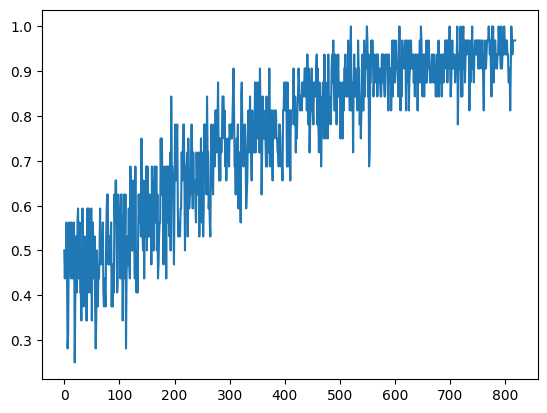

In [ ]:
import matplotlib.pyplot as plt
plt.plot(accuracies)

In [ ]:
truths = []
preds = []

In [ ]:
len(face_test_x) // batch_size
model.model.is_training = False

In [ ]:
len(test_loader.y), len(test_loader.face), len(test_loader.data_list)

(8745, 3858, 3858)

In [ ]:
test_loader.reset()
print(test_loader.y)
preds, truths = [], []
truth_set = []
while True:
    input_list, truth_list = test_loader.get_batch(batch_size=batch_size)
    if input_list is None:
        break
    output = model.test_step(input_list)
    truth_list = [int(label) for label in truth_list]
    truth_set.extend(truth_list)
    truths.extend(truth_list)
    preds.extend(output.detach().numpy())

print(list(set(truth_set)))

tensor([  0,   0,   0,  ..., 499, 499, 499])
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,

In [ ]:
preds = np.argmax(preds, axis=1)

accuracy_score(preds, truths)

0.0020833333333333333

In [ ]:
set(truths)

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


In [ ]:
preds, truths

(array([366,  20, 497, ..., 246, 267, 409], dtype=int64),
 [204,
  8,
  191,
  82,
  184,
  185,
  107,
  83,
  85,
  7,
  135,
  143,
  117,
  119,
  77,
  174,
  130,
  9,
  114,
  216,
  64,
  114,
  123,
  64,
  127,
  195,
  216,
  62,
  108,
  189,
  2,
  46,
  76,
  199,
  103,
  142,
  163,
  184,
  187,
  39,
  72,
  31,
  127,
  53,
  72,
  29,
  112,
  202,
  63,
  181,
  165,
  191,
  178,
  202,
  125,
  25,
  59,
  193,
  55,
  197,
  204,
  21,
  170,
  209,
  214,
  176,
  72,
  98,
  160,
  56,
  99,
  135,
  141,
  42,
  4,
  13,
  162,
  136,
  164,
  6,
  69,
  60,
  30,
  72,
  204,
  39,
  18,
  123,
  14,
  138,
  197,
  170,
  150,
  190,
  48,
  60,
  103,
  208,
  171,
  41,
  92,
  84,
  70,
  154,
  22,
  167,
  212,
  84,
  174,
  197,
  35,
  199,
  157,
  35,
  165,
  12,
  201,
  163,
  212,
  133,
  84,
  85,
  26,
  34,
  28,
  212,
  134,
  54,
  56,
  42,
  49,
  58,
  58,
  129,
  136,
  130,
  39,
  80,
  132,
  144,
  207,
  44,
  86,
  178,
  71,

In [ ]:
import numpy as np

def find_closest_embeddings_numpy(embeddings):
    """
    Finds the closest embedding (by cosine similarity) for each embedding in the input.

    Args:
        embeddings (np.ndarray): A 2D array of shape (N, D), where N is the number
                                  of embeddings and D is the embedding dimension.

    Returns:
        closest_indices (np.ndarray): A 1D array of shape (N,) containing the index
                                      of the closest embedding for each embedding.
        distance_matrix (np.ndarray): A 2D array of shape (N, N) containing cosine
                                       distances between embeddings.
    """
    # Normalize embeddings to compute cosine similarity
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norms

    # Compute cosine similarity matrix
    similarity_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)

    # Convert similarity to cosine distance (1 - cosine similarity)
    distance_matrix = 1 - similarity_matrix

    # Fill diagonal with a large value to ignore self-similarity
    np.fill_diagonal(distance_matrix, np.inf)

    # Find the index of the minimum distance for each row
    closest_indices = np.argmin(distance_matrix, axis=1)

    return closest_indices, distance_matrix


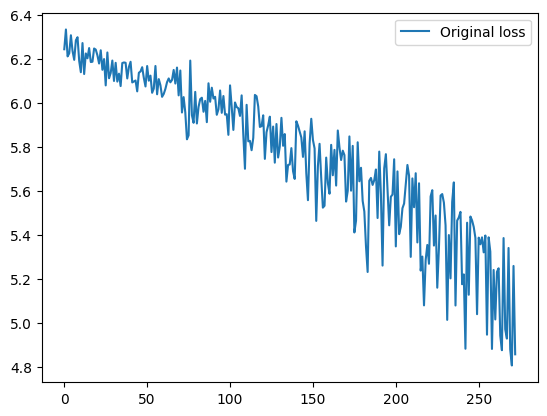

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
# Function to create a Gaussian kernel
def gaussian_kernel(size, sigma=1):
    x = np.linspace(-size // 2, size // 2, size)
    kernel = np.exp(-x**2 / (2 * sigma**2))
    kernel /= np.sum(kernel)
    return kernel

sigma = 5
kernel_size = 11  # Choose an odd number
kernel = gaussian_kernel(kernel_size, sigma)
smoothed_vector = np.convolve(losses, kernel, mode='same')

plt.plot(losses, label="Original loss")
# plt.plot(smoothed_vector[5:-5], label="Smoothed loss")
plt.legend()
# plt.title("EmbraceNet Loss")
